In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = "/content/drive/MyDrive/CodeSpace/CUHK/CMSC_CV/EdgeDetection/example_1.png"
# img_path = "/content/drive/MyDrive/CodeSpace/CUHK/CMSC_CV/EdgeDetection/example_2.jfif"

# 读取图像
img = cv2.imread(img_path, cv2.IMREAD_COLOR)

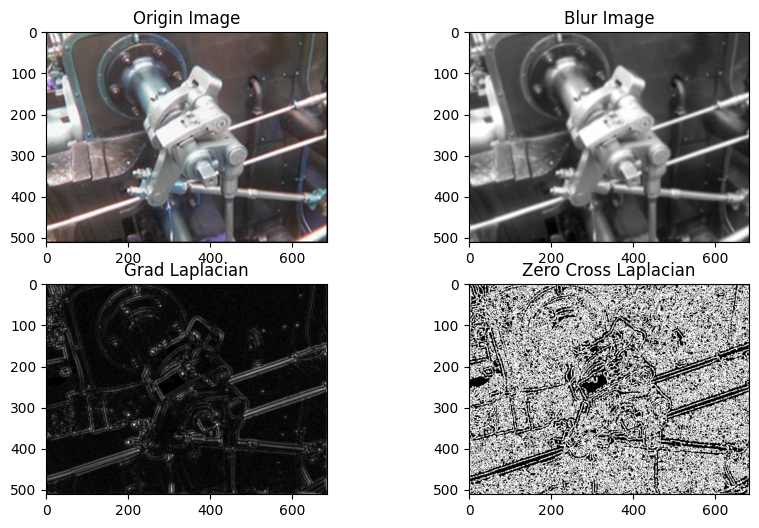

In [ ]:
"""
  直接使用cv2的实现：cv2.Laplacian()

"""
scale = 1
delta = 0
ddepth = cv2.CV_16S
ksize = 3

# 使用高斯模糊
blur = cv2.GaussianBlur(img, (11, 11), 0)
# 转为灰度图
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

# 计算水平方向的 Laplacian 二阶梯度
grad = cv2.Laplacian(gray, ddepth, ksize=ksize, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
# 将梯度图转换为8bitU图像（0~255）,如果计算后的值大于255，则将其取为255（8位最大值）
abs_grad = cv2.convertScaleAbs(grad)
cv2.imwrite("/content/drive/MyDrive/CodeSpace/CUHK/CMSC_CV/EdgeDetection/example_1_edge.png", abs_grad)

# 实现zero cross
# 参考 https://stackoverflow.com/questions/25105916/laplacian-of-gaussian-in-opencv-how-to-find-zero-crossings
LoG = cv2.Laplacian(gray, cv2.CV_16S)
minLoG = cv2.morphologyEx(LoG, cv2.MORPH_ERODE, np.ones((3,3)))
maxLoG = cv2.morphologyEx(LoG, cv2.MORPH_DILATE, np.ones((3,3)))
zeroCross = np.logical_or(np.logical_and(minLoG < 0,  LoG > 0), np.logical_and(maxLoG > 0, LoG < 0))

# 显示结果
plt.figure(figsize=(10, 6))  # 设置宽度为10英寸，高度为6英寸
plt.subplot(2, 2, 1), plt.imshow(img, cmap='gray'), plt.title('Origin Image')
plt.subplot(2, 2, 2), plt.imshow(gray, cmap='gray'), plt.title('Blur Image')
plt.subplot(2, 2, 3), plt.imshow(abs_grad, cmap='gray'), plt.title('Grad Laplacian')
plt.subplot(2, 2, 4), plt.imshow(zeroCross, cmap='gray'), plt.title('Zero Cross Laplacian')
plt.show()

use kernel:
(13, 13)


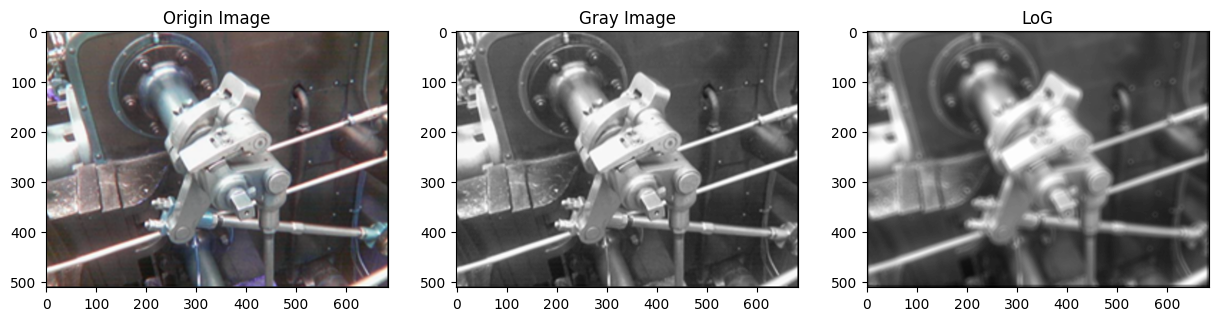

In [25]:
"""
  实现LoG: Laplacian of Gaussian 算子
  参考：https://blog.csdn.net/qq_44116998/article/details/124718383
"""

import numpy as np
from scipy import signal
import cv2


def createLoGKernel(sigma, size):
    H, W = size
    r, c = np.mgrid[0:H:1, 0:W:1]
    r -= (H - 1) // 2
    c -= (W - 1) // 2
    # print(r, c)
    sigma2 = pow(sigma, 2.0)
    norm2 = np.power(r, 2.0) + np.power(c, 2.0)
    multiply = - (1/(np.pi * pow(sigma, 4.0)))
    LoGKernel = multiply * (norm2 / sigma2 - 1) * np.exp(-norm2 / (2 * sigma2))
    # print(LoGKernel)
    return LoGKernel

# 使用scipy进行卷积
def LoG(image, sigma, size, _boundary='symm'):
    loGKernel = createLoGKernel(sigma, size)
    print(f"use kernel:\n{loGKernel.shape}")
    img_conv_log = signal.convolve2d(image, loGKernel, 'same', boundary=_boundary)
    return img_conv_log

# 读取图像
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
# 转为灰度图
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_conv_log_1 = LoG(gray, 2, (13, 13), 'fill')
abs_grad_LoG_1 = cv2.convertScaleAbs(img_conv_log_1)

# 显示结果
plt.figure(figsize=(15, 9))  # 设置宽度为10英寸，高度为6英寸
plt.subplot(1, 3, 1), plt.imshow(img, cmap='gray'), plt.title('Origin Image')
plt.subplot(1, 3, 2), plt.imshow(gray, cmap='gray'), plt.title('Gray Image')
plt.subplot(1, 3, 3), plt.imshow(abs_grad_LoG_1, cmap='gray'), plt.title('LoG')
plt.show()

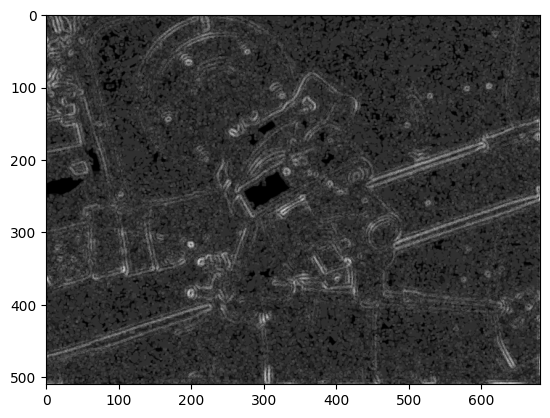

In [31]:
import numpy as np
import scipy.misc
import cv2  # using opencv as I am not too familiar w/ scipy yet, sorry


def laplace_of_gaussian(gray_img, sigma=1., kappa=0.75, pad=False):
    """
    Applies Laplacian of Gaussians to grayscale image.

    :param gray_img: image to apply LoG to
    :param sigma:    Gauss sigma of Gaussian applied to image, <= 0. for none
    :param kappa:    difference threshold as factor to mean of image values, <= 0 for none
    :param pad:      flag to pad output w/ zero border, keeping input image size
    """
    assert len(gray_img.shape) == 2
    img = cv2.GaussianBlur(gray_img, (0, 0), sigma) if 0. < sigma else gray_img
    img = cv2.Laplacian(img, cv2.CV_16S)
    rows, cols = img.shape[:2]
    # min/max of 3x3-neighbourhoods
    min_map = np.minimum.reduce(list(img[r:rows-2+r, c:cols-2+c]
                                     for r in range(3) for c in range(3)))
    max_map = np.maximum.reduce(list(img[r:rows-2+r, c:cols-2+c]
                                     for r in range(3) for c in range(3)))
    # bool matrix for image value positiv (w/out border pixels)
    pos_img = 0 < img[1:rows-1, 1:cols-1]
    # bool matrix for min < 0 and 0 < image pixel
    neg_min = min_map < 0
    neg_min[1 - pos_img] = 0
    # bool matrix for 0 < max and image pixel < 0
    pos_max = 0 < max_map
    pos_max[pos_img] = 0
    # sign change at pixel?
    zero_cross = neg_min + pos_max
    # values: max - min, scaled to 0--255; set to 0 for no sign change
    value_scale = 255. / max(1., img.max() - img.min())
    values = value_scale * (max_map - min_map)
    values[1 - zero_cross] = 0.
    # optional thresholding
    if 0. <= kappa:
        thresh = float(np.absolute(img).mean()) * kappa
        values[values < thresh] = 0.
    log_img = values.astype(np.uint8)
    if pad:
        log_img = np.pad(log_img, pad_width=1, mode='constant', constant_values=0)
    return log_img


"""Test routine"""
# load grayscale image
# 读取图像
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
# 转为灰度图
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# apply LoG
log = laplace_of_gaussian(gray, sigma=2)
# display
plt.imshow(log, cmap='gray')